# Data Preparation

First the Algorithm reads a file and make pre-processing

In [22]:
import re
import numpy as np
import pandas as pd

In [23]:
data = pd.read_csv('rozetka/products_comments.zip', header=0, compression='zip').fillna('')

У файлі я розділив коменти на звичайний текст, переваги та недоліки. На разі, зліплюємо все в один текст

In [24]:
data['total_comment'] = data['Normal_text'] + '. ' + data['Pro'] + '. ' + data['Con']

In [25]:
def clean_text(text):
    """
    prepare the text: to lowercase, remove links, 
    change numbers to ukr. word, channge endlish words to ukr. word
    """
    text = text.lower()
    text = re.sub(r'(?:https?://|www\.)[^\s]+', '', text)
    text = re.sub(r'[0-9]+', ' інти ', text)
    text = re.sub(r'[a-z]+', ' латина ', text)
    text = re.sub(r'ґ', 'г', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip(' .,')

In [26]:
data['total_comment'] = data['total_comment'].apply(clean_text)

In [27]:
data['Stars'].value_counts()

5    4031
4    1429
3     391
2     214
1     187
Name: Stars, dtype: int64

Як ми бачимо, вибірка дуже не здалансована

In [28]:
data['len_symols'] = data['total_comment'].str.len()

In [29]:
data['len_words'] = data['total_comment'].str.split().str.len()

In [30]:
data.groupby(['Stars']).mean()

,len_symols,len_words
Stars,,
1,291.117647,44.508021
2,330.331776,50.682243
3,306.644501,46.774936
4,285.468859,43.776067
5,251.395932,38.701811


з даного аналізу можна побачити, що чим довший файл, тим скоріш це буде негативний відгук

Я вирішив розділити коментарі на 3 класи: exelent для 5*, normal для 4*, bad для 3, 2 та 1*

In [31]:
data.replace(to_replace=[5, 4, 3, 2, 1], value=[2, 1, 1, 1, 0], inplace=True)
data.rename(columns = {'Stars': 'label'}, inplace=True)

In [32]:
# data.head()
data['label'].value_counts()

2    4031
1    2034
0     187
Name: label, dtype: int64

## Split to train and test datasets

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support, f1_score, roc_auc_score, roc_curve, auc

In [34]:
columns_to_drop = ['Response', 'Normal_text', 'Pro', 'Con']

X_train, X_test, y_train, y_test = train_test_split(data['total_comment'],
                                                    data['label'],
                                                    test_size=0.2,
                                                    random_state=100)

## Baseline
Для бейзлайну я обрав звичайний векторайзер та NaiveBayes класифікатор для декількох класів

In [35]:
bow_transformer = CountVectorizer().fit(X_train)

In [36]:
# how many unique words in the comments
len(bow_transformer.vocabulary_)

22669

In [37]:
feature_mapping = bow_transformer.get_feature_names()

In [38]:
feature_mapping[:30]

['______',
 'аа',
 'абгрейд',
 'абгрейда',
 'абгрейду',
 'аби',
 'або',
 'абож',
 'абонент',
 'абощо',
 'абслютно',
 'абсолютна',
 'абсолютно',
 'абушери',
 'абушури',
 'аваль',
 'аварійних',
 'аварійно',
 'аварійного',
 'аварійному',
 'аварійній',
 'авжеж',
 'авр',
 'авт',
 'авто',
 'автобусом',
 'автобусі',
 'автовиключення',
 'автовимикання',
 'автовідключення']

Видно, що дуже багато невідомих слів та слів у різних відмінках

In [39]:
X_train_vectorized = bow_transformer.transform(X_train)

cross validation to choose the best alpha based on the accuracy and f1 score for the models:

In [40]:
from sklearn.model_selection import cross_validate
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

alphas = (0.001, 0.01, 0.1, 1.0, 10.0)
for a in alphas:
    print('alpha={}'.format(a))
    model_temp = MultinomialNB(alpha=a)
    model_temp.fit(X_train_vectorized, y_train)
    scores = cross_validate(model_temp, X_train_vectorized, y_train, cv=4, scoring=scoring, return_train_score=False)
    for score, values in scores.items():
        print('score: {}\t{}'.format(score, values.mean()))
    print()

alpha=0.001
score: fit_time	0.0055086612701416016
score: score_time	0.004562854766845703
score: test_precision_macro	0.5029913256056133
score: test_recall_macro	0.46670146179092575
score: test_f1_macro	0.4782578057641919
score: test_accuracy	0.6680611209351174

alpha=0.01
score: fit_time	0.005814313888549805
score: score_time	0.004449248313903809
score: test_precision_macro	0.4990314892338483
score: test_recall_macro	0.507734615188812
score: test_f1_macro	0.5010559138689991
score: test_accuracy	0.6672600002944002

alpha=0.1
score: fit_time	0.005565047264099121
score: score_time	0.004021704196929932
score: test_precision_macro	0.4994113038690956
score: test_recall_macro	0.5291386889925391
score: test_f1_macro	0.5084020423691845
score: test_accuracy	0.6726643227291665

alpha=1.0
score: fit_time	0.005890488624572754
score: score_time	0.004757940769195557
score: test_precision_macro	0.47209588600812946
score: test_recall_macro	0.42003099292547014
score: test_f1_macro	0.41923469247846934
sc

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

So let's choose alpha to 0.1 because  the F1 score is the better in this case

In [41]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)
predictions = model.predict(bow_transformer.transform(X_test))

Get the most valuable words for the model

In [75]:
feature_names = bow_transformer.get_feature_names()

for i, class_label in enumerate([2, 1, 0]):
    top30 = np.argsort(model.coef_[i])[-50:]
    print("%s: %s" % (class_label, ", ".join(feature_names[x] for x in top30 if x < len(feature_names))))
    print()

2: так, мені, кабель, роботи, раз, один, можна, гроші, було, він, ні, про, більше, користування, мене, тому, чи, коли, від, працювати, навіть, то, перестав, працює, тільки, рекомендую, немає, ціна, вже, якість, все, після, навушники, просто, для, це, по, за, до, через, при, як, дуже, але, звук, що, латина, на, інти, не

1: таку, його, тільки, навіть, гроші, досить, мікрофон, просто, добре, вже, тому, без, немає, дизайн, він, коли, звуку, після, мене, чи, ще, ціну, можна, від, якщо, працює, хороший, то, так, по, через, навушники, все, при, якість, це, ціна, до, та, як, дуже, за, що, але, для, звук, на, латина, не, інти

0: гроші, звучання, таку, монітор, купив, добре, звуку, чудовий, тому, вже, через, супер, то, рекомендую, поки, без, якщо, дизайн, задоволений, мене, так, ще, можна, просто, чи, ціну, хороший, працює, при, від, по, навушники, немає, це, ціна, все, до, якість, та, як, але, дуже, що, за, для, звук, на, не, латина, інти



There are a lot of words that have no any valuable meaning in the most valuable features. Later, I'll try to put it to stop-words

### Evalutaion

To evaluate the model I used several metrics: Precision, Recall, F1 score and ROC AUC metrics.
As the model is multilabel classification, I used option average 'weighted' and 'macro'. First option calculates metrics for each label, and find their average, weighted by support (the number of true instances for each label). Second one calculates metrics for each label, and find their unweighted mean

In [44]:
print('Accuracy:', accuracy_score(y_test, predictions))
print()
print('Precision weighted:', precision_score(y_test, predictions, average='weighted'))
print('Recall weighted:', recall_score(y_test, predictions, average='weighted'))
print('F1 score weighted:', f1_score(y_test, predictions, average='weighted'))
print()
print('Precision macro:', precision_score(y_test, predictions, average='macro'))
print('Recall macro:', recall_score(y_test, predictions, average='macro'))
print('F1 score macro:', f1_score(y_test, predictions, average='macro'))

Accuracy: 0.656274980016

Precision weighted: 0.63052670558
Recall weighted: 0.656274980016
F1 score weighted: 0.635631129692

Precision macro: 0.487787913556
Recall macro: 0.439210374699
F1 score macro: 0.450151373777


This is a not a good result, because if we set all labels to 2 (excelent), we have Accuracy 0.63

In [45]:
classes = ['excelent', 'good', 'bad']
conf_matrix_temp = confusion_matrix(y_test, predictions, labels=[2, 1, 0])
conf_matrix_baseline = pd.DataFrame(conf_matrix_temp, columns=classes, index=classes)

In [46]:
conf_matrix_baseline

,excelent,good,bad
excelent,657,125,5
good,259,160,8
bad,9,24,4


In [47]:
supp_matrix_temp = [list(x) for x in precision_recall_fscore_support(y_test, predictions, labels=[2, 1, 0])]
supp_matrix_baseline = pd.DataFrame(supp_matrix_temp, columns=classes, 
                                    index=['precision', 'recall', 'f1', 'total'])

In [48]:
supp_matrix_baseline

,excelent,good,bad
precision,0.710270,0.517799,0.235294
recall,0.834816,0.374707,0.108108
f1,0.767523,0.434783,0.148148
total,787.000000,427.000000,37.000000


As expected, we have good results of the class 'excelent' and bad results for others. This situation is happened because the classes are very unbalanced.

Let's calculate ROC AUC average for the classes and for the each class

In [49]:
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pr_bin = label_binarize(predictions, classes=[0, 1, 2])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pr_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_pr_bin.ravel(), pos_label=2)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


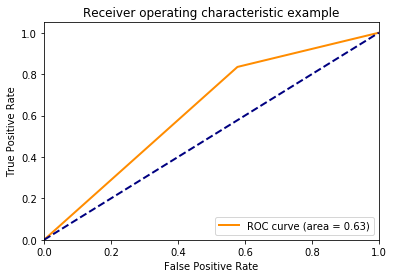

In [51]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

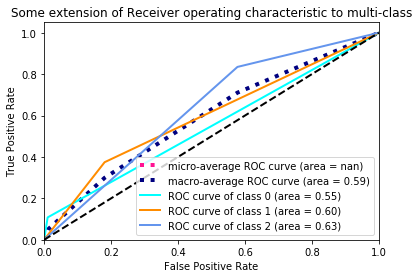

In [52]:
import numpy as np
from scipy import interp
from itertools import cycle

n_classes = 3

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

So, the results of the model don't satisfies us and the further improvement is needed

# Add sentiment score

Create sentiment dictionary from the file from https://github.com/lang-uk/tone-dict-uk

In [53]:
import csv

sentiment_dict = dict()

with open('files/tone-dict-uk.tsv', newline='', ) as csvfile:
    senti_reader = csv.reader(csvfile, delimiter='\t')
    for row in senti_reader:
        sentiment_dict[row[0].lower()] = int(row[1])

In [54]:
def calculate_text_sentiment(text):
    pos = 0
    neg = 0
    tokens = [x.strip('.,/!#?:;"_') for x in text.split()]
    for t in tokens:
        word_score = sentiment_dict.get(t, 0)
        if word_score > 0:
            pos += word_score
        elif word_score < 0:
            neg += word_score
    return pos, abs(neg)

Add 2 new columns of total possitive and total negative score

In [55]:
data['pos'], data['neg'] = zip(*data['total_comment'].apply(calculate_text_sentiment))

In [56]:
data.groupby(['label']).mean()

,len_symols,len_words,pos,neg
label,,,,
0,291.117647,44.475936,0.433155,0.684492
1,294.258112,44.972468,1.052114,0.369715
2,251.393451,38.520714,1.242620,0.160754


Also, let's add length of text feature to classificatior

In [57]:
X_train_senti, X_test_senti, y_train_senti, y_test_senti = train_test_split(
                                                    data[['total_comment', 'pos', 'neg', 'len_words']],
                                                    data['label'],
                                                    test_size=0.2,
                                                    random_state=100)

In [58]:
X_train_senti.head()

,total_comment,pos,neg,len_words
719,"для звичайних повсякденних задач, та мультимед...",5,0,66
1017,"повторювати всі попередні відгуки, типу компак...",0,2,254
4670,купив недавно ці наушники . дуже порадували . ...,4,3,80
2403,для своєї ціни це сепер колонка. але не вистач...,0,0,14
220,чи піде інти віндуза?,0,0,1


In [59]:
bow_transformer = CountVectorizer().fit(X_train_senti['total_comment'])
X_text = pd.DataFrame(bow_transformer.transform(X_train_senti['total_comment']).todense(),
                      columns=bow_transformer.get_feature_names(), index=X_train_senti.index)
print('text shape: {}'.format(X_text.shape))
X_numbers = X_train_senti[['pos', 'neg', 'len_words']]
X = pd.concat([X_text, X_numbers], axis=1, join="inner")
print('text and features shape: {}'.format(X.shape))

text shape: (5001, 22669)
text and features shape: (5001, 22672)


To understand if the model is better with sentiment score let's make the same NaiveBayes model with the same alpha but  we can try to balance the feature "pos" and "neg" with the coeficient. Let's assume the possible coeficients: 0.5, 1, 2, 5, 10, 100

In [63]:
X.head()

,______,аа,абгрейд,абгрейда,абгрейду,аби,або,абож,абонент,абощо,...,їхня,їхні,їхній,їхніми,їхніх,їєднання,її,pos,neg,len_words
719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.0,0.0,66
1017,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,2.0,254
4670,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,3.0,80
2403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,14
220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1


In [61]:
senti_k = (0.5, 1, 2, 3, 4, 5)
curves_dict = {}

for k in senti_k:
    print('k:', k)
    X[['pos', 'neg']] = X[['pos', 'neg']] * k
    model_temp = MultinomialNB(alpha=0.1)
    model_temp.fit(X, y_train_senti)
    scores = cross_validate(model_temp, X, y_train, cv=4, scoring=scoring, return_train_score=False)
    for score, values in scores.items():
        curves_dict.setdefault(score, []).append(values.mean())
        print('\tscore: {}\t{}'.format(score, values.mean()))
    print()
    X[['pos', 'neg']] = X[['pos', 'neg']] / k

k: 0.5
	score: fit_time	1.3630646467208862
	score: score_time	0.8601809144020081
	score: test_precision_macro	0.5042516784629102
	score: test_recall_macro	0.5223382272864466
	score: test_f1_macro	0.5102704268631646
	score: test_accuracy	0.6772632049044511

k: 1
	score: fit_time	1.3635414838790894
	score: score_time	0.8693533539772034
	score: test_precision_macro	0.5074461323032615
	score: test_recall_macro	0.5271947155984634
	score: test_f1_macro	0.5141253144380659
	score: test_accuracy	0.6782620852877347

k: 2
	score: fit_time	1.4793532490730286
	score: score_time	0.9502726793289185
	score: test_precision_macro	0.5126468891535115
	score: test_recall_macro	0.5342864745530486
	score: test_f1_macro	0.5198374376058603
	score: test_accuracy	0.6816624068239403

k: 3
	score: fit_time	1.395893931388855
	score: score_time	0.8729512691497803
	score: test_precision_macro	0.5103827747099644
	score: test_recall_macro	0.5330393533639697
	score: test_f1_macro	0.5174962430669532
	score: test_accuracy

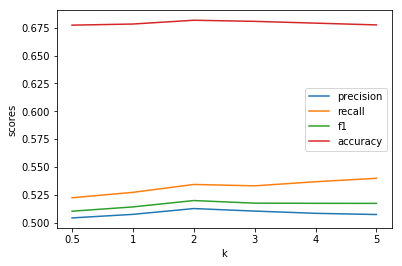

In [62]:
x = [str(x) for x in senti_k]
for name, values in curves_dict.items():
    if 'time' not in name:
        label = name.split('_')[1]
        plt.plot(x, values, label=label)

plt.ylabel('scores')
plt.xlabel('k')
plt.legend()
plt.show()

The difference in score not so big for k=1 and k=2, but 2 is sligthly better, so I'm going to multiply all for 2

In [64]:
k = 2
X[['pos', 'neg']] = X[['pos', 'neg']] * k
model_senti = MultinomialNB(alpha=0.1)
model_senti.fit(X, y_train_senti)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [65]:
X_test_text = pd.DataFrame(bow_transformer.transform(X_test_senti['total_comment']).todense(),
                           columns=bow_transformer.get_feature_names(), index=X_test_senti.index)
print('text shape: {}'.format(X_test_text.shape))
X_test_numbers = X_test_senti[['pos', 'neg', 'len_words']]
X_test_numbers[['pos', 'neg']] = X_test_numbers[['pos', 'neg']] * k
X_test_s = pd.concat([X_test_text, X_test_numbers], axis=1, join="inner")
print('text and features shape: {}'.format(X_test_s.shape))
predictions_senti = model_senti.predict(X_test_s)

text shape: (1251, 22669)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


text and features shape: (1251, 22672)


### Evalutaion with sentiment score model

Let's make the same model's evaluation pipline as it was for simple model

In [66]:
print('Accuracy:', accuracy_score(y_test_senti, predictions_senti))
print()
print('Precision weighted:', precision_score(y_test_senti, predictions_senti, average='weighted'))
print('Recall weighted:', recall_score(y_test_senti, predictions_senti, average='weighted'))
print('F1 score weighted:', f1_score(y_test_senti, predictions_senti, average='weighted'))
print()
print('Precision macro:', precision_score(y_test_senti, predictions_senti, average='macro'))
print('Recall macro:', recall_score(y_test_senti, predictions_senti, average='macro'))
print('F1 score macro:', f1_score(y_test_senti, predictions_senti, average='macro'))

Accuracy: 0.673860911271

Precision weighted: 0.6494182343
Recall weighted: 0.673860911271
F1 score weighted: 0.652320414407

Precision macro: 0.52555633236
Recall macro: 0.451385186507
F1 score macro: 0.46635887432


<b>Previuous results:</b>
<li>Accuracy: 0.656274980016
<li>Precision weighted: 0.63052670558
<li>Recall weighted: 0.656274980016
<li>F1 score weighted: 0.635631129692

After comparison, we can see that results with positive and negative sentiment score and length of comment is better but we have more ideas to improve it.

In [67]:
conf_matrix_temp = confusion_matrix(y_test_senti, predictions_senti, labels=[2, 1, 0])
conf_matrix_baseline_senti = pd.DataFrame(conf_matrix_temp, columns=classes, index=classes)

Previous confusion matrix

In [68]:
conf_matrix_baseline

,excelent,good,bad
excelent,657,125,5
good,259,160,8
bad,9,24,4


In [69]:
conf_matrix_baseline_senti

,excelent,good,bad
excelent,671,113,3
good,253,168,6
bad,8,25,4


In [70]:
y_bin_senti = label_binarize(y_test_senti, classes=[0, 1, 2])
y_pr_bin_senti = label_binarize(predictions_senti, classes=[0, 1, 2])


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_senti[:, i], y_pr_bin_senti[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_senti.ravel(), y_pr_bin_senti.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

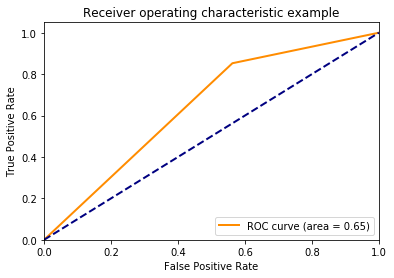

In [71]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

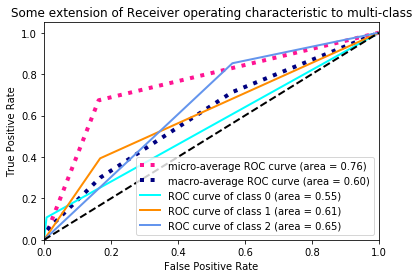

In [72]:
n_classes = 3

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

As previuos one, this result is not the goal, I am looking for.

## Additional improvements

Check for possible stop words in Ukrainian. Let's calculate frequency of the words in our corpus

In [73]:
import operator
from collections import OrderedDict

cv = CountVectorizer()
cv_fit = cv.fit_transform(X_train_senti['total_comment'])

features = cv.get_feature_names()
tf = np.sum(cv_fit.toarray(), axis=0)
word_count = {f: int(tf[i]) for i, f in enumerate(features)}
wc = OrderedDict(sorted(word_count.items(), key=operator.itemgetter(1), reverse=True))
print(list(wc.items())[:200])

[('інти', 6912), ('латина', 6233), ('не', 5583), ('на', 4263), ('звук', 2040), ('для', 1874), ('що', 1814), ('за', 1699), ('дуже', 1611), ('але', 1565), ('як', 1280), ('та', 1151), ('до', 1084), ('якість', 1055), ('ціна', 1022), ('це', 995), ('все', 961), ('навушники', 823), ('немає', 781), ('по', 737), ('при', 726), ('від', 644), ('працює', 634), ('хороший', 631), ('так', 620), ('через', 601), ('ціну', 589), ('можна', 582), ('то', 569), ('чи', 567), ('ще', 557), ('якщо', 555), ('мене', 539), ('просто', 539), ('дизайн', 508), ('без', 491), ('вже', 462), ('задоволений', 446), ('тому', 434), ('звуку', 423), ('після', 410), ('поки', 406), ('рекомендую', 405), ('добре', 393), ('коли', 376), ('він', 375), ('гроші', 374), ('купив', 366), ('супер', 363), ('навіть', 359), ('їх', 357), ('таку', 355), ('звучання', 352), ('досить', 349), ('вони', 335), ('тільки', 335), ('більше', 333), ('його', 321), ('було', 311), ('монітор', 307), ('мікрофон', 307), ('вуха', 305), ('буде', 304), ('під', 304), (

And the most valuable words for the model are:

In [78]:
feature_names = bow_transformer.get_feature_names()
tops = []

for i, class_label in enumerate([2, 1, 0]):
    top100 = np.argsort(model_senti.coef_[i])[-100:]
    tops.append(top100)
    print("%s: %s" % (class_label, ", ".join(feature_names[x] for x in top30 if x < len(feature_names))))
    print()

2: монітор, купив, добре, звуку, чудовий, тому, вже, через, супер, то, рекомендую, поки, без, якщо, дизайн, задоволений, мене, так, ще, можна, просто, чи, ціну, хороший, працює, при, від, по, навушники, немає, це, ціна, все, до, якість, та, як, але, дуже, що, за, для, звук, на, не, латина, інти

1: монітор, купив, добре, звуку, чудовий, тому, вже, через, супер, то, рекомендую, поки, без, якщо, дизайн, задоволений, мене, так, ще, можна, просто, чи, ціну, хороший, працює, при, від, по, навушники, немає, це, ціна, все, до, якість, та, як, але, дуже, що, за, для, звук, на, не, латина, інти

0: монітор, купив, добре, звуку, чудовий, тому, вже, через, супер, то, рекомендую, поки, без, якщо, дизайн, задоволений, мене, так, ще, можна, просто, чи, ціну, хороший, працює, при, від, по, навушники, немає, це, ціна, все, до, якість, та, як, але, дуже, що, за, для, звук, на, не, латина, інти



What are the words, that can be found in all classes?

In [81]:
common_index = set(tops[0]).intersection(tops[1]).intersection(tops[2])
common_words = [feature_names[x] for x in common_words if x < len(feature_names)]

In [82]:
common_words

['якщо',
 'колонки',
 'все',
 'латина',
 'можна',
 'та',
 'було',
 'мені',
 'вони',
 'при',
 'через',
 'ціна',
 'інти',
 'якість',
 'то',
 'його',
 'це',
 'вже',
 'так',
 'від',
 'цей',
 'він',
 'кабель',
 'ще',
 'на',
 'після',
 'чи',
 'звук',
 'немає',
 'що',
 'щоб',
 'для',
 'гроші',
 'тільки',
 'купив',
 'навушники',
 'по',
 'до',
 'просто',
 'за',
 'тому',
 'але',
 'працює',
 'як',
 'дизайн',
 'рекомендую',
 'навіть',
 'роботи',
 'дуже',
 'ці',
 'не',
 'більше',
 'коли',
 'мікрофон',
 'без',
 'їх',
 'мене']

In [83]:
stop_words_ua = common_words

Prepare the model with Stop words. The shape of new DF should me 57 columns less

In [85]:
bow_stop = CountVectorizer(stop_words=stop_words_ua).fit(X_train_senti['total_comment'])
X_text_stop = pd.DataFrame(bow_stop.transform(X_train_senti['total_comment']).todense(),
                      columns=bow_stop.get_feature_names(), index=X_train_senti.index)
print('text shape: {}'.format(X_text_stop.shape))
X_numb_stop = X_train_senti[['pos', 'neg', 'len_words']]
X_numb_stop[['pos', 'neg']] = X_numb_stop[['pos', 'neg']] * k
X_stop = pd.concat([X_text_stop, X_numb_stop], axis=1, join="inner")
print('text and features shape: {}'.format(X_stop.shape))

text shape: (5001, 22612)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


text and features shape: (5001, 22615)


In [86]:
model_stop = MultinomialNB(alpha=0.1)
model_stop.fit(X_stop, y_train_senti)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [87]:
X_test_stop = pd.DataFrame(bow_stop.transform(X_test_senti['total_comment']).todense(),
                           columns=bow_stop.get_feature_names(), index=X_test_senti.index)
print('text shape: {}'.format(X_test_stop.shape))
X_test_num_stop = X_test_senti[['pos', 'neg', 'len_words']]
X_test_num_stop[['pos', 'neg']] = X_test_num_stop[['pos', 'neg']] * k
X_test_stop = pd.concat([X_test_stop, X_test_num_stop], axis=1, join="inner")
print('text and features shape: {}'.format(X_test_stop.shape))
predictions_stop = model_stop.predict(X_test_stop)

text shape: (1251, 22612)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


text and features shape: (1251, 22615)


In [88]:
print('Accuracy:', accuracy_score(y_test_senti, predictions_stop))
print()
print('Precision weighted:', precision_score(y_test_senti, predictions_stop, average='weighted'))
print('Recall weighted:', recall_score(y_test_senti, predictions_stop, average='weighted'))
print('F1 score weighted:', f1_score(y_test_senti, predictions_stop, average='weighted'))
print()
print('Precision macro:', precision_score(y_test_senti, predictions_stop, average='macro'))
print('Recall macro:', recall_score(y_test_senti, predictions_stop, average='macro'))
print('F1 score macro:', f1_score(y_test_senti, predictions_stop, average='macro'))

Accuracy: 0.665867306155

Precision weighted: 0.639968001074
Recall weighted: 0.665867306155
F1 score weighted: 0.643918113294

Precision macro: 0.51084235425
Recall macro: 0.445007148384
F1 score macro: 0.458506090999


<b>Previuos results:</b>
<li>Accuracy: 0.673860911271
<li>Precision weighted: 0.6494182343
<li>Recall weighted: 0.673860911271
<li>F1 score weighted: 0.652320414407

Let me assume some other stop words based on my experience

In [ ]:
['на', 'для', 'що', 'як', /'та'/, /'до'/, 'це', 'по', 'при', 'від', /'через'/, /'то'/, /'якщо'/, 'вже', 'тому', 'коли',
                 'таку', 'вони', 'його', 'було', 'під', 'мені', 'цей', {'такі', 'щоб', 'свою', 'про', 'який', 'ці', 'те', 'них',
                 'цього', 'бо', 'або', 'які', 'із', 'свої', 'хто', 'собі', 'того', 'теж', 'вона', 'яка', 'цьому', 
                 'латина', 'інти', 'аа', 'не', 'а', 'над', 'в', 'у', 'де', 'за', 'із']

In [251]:
stop_words_my = ['на', 'для', 'що', 'як', 'це', 'по', 'при', 'від', 'вже', 'тому', 'коли', 'таку', 'вони', 'його', 'було',
                 'під', 'мені', 'цей', 'такі', 'щоб', 'свою', 'про', 'який', 'ці', 'те', 'них',
                 'цього', 'бо', 'або', 'які', 'із', 'свої', 'хто', 'собі', 'того', 'теж', 'вона', 'яка', 'цьому', 
                 'латина', 'інти', 'аа', 'не', 'а', 'над', 'в', 'у', 'де', 'за', 'із']

In [252]:
bow_stop2 = CountVectorizer(stop_words=stop_words_my).fit(X_train_senti['total_comment'])
X_text_stop2 = pd.DataFrame(bow_stop2.transform(X_train_senti['total_comment']).todense(),
                      columns=bow_stop2.get_feature_names(), index=X_train_senti.index)
print('text shape: {}'.format(X_text_stop2.shape))
X_stop2 = pd.concat([X_text_stop2, X_numb_stop], axis=1, join="inner")
print('text and features shape: {}'.format(X_stop2.shape))

text shape: (5001, 22623)
text and features shape: (5001, 22626)


In [253]:
model_stop2 = MultinomialNB(alpha=0.1)
model_stop2.fit(X_stop2, y_train_senti)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [254]:
X_test_stop2 = pd.DataFrame(bow_stop2.transform(X_test_senti['total_comment']).todense(),
                           columns=bow_stop2.get_feature_names(), index=X_test_senti.index)
print('text shape: {}'.format(X_test_stop2.shape))
X_test_stop2 = pd.concat([X_test_stop2, X_test_num_stop], axis=1, join="inner")
print('text and features shape: {}'.format(X_test_stop2.shape))
predictions_stop2 = model_stop2.predict(X_test_stop2)

text shape: (1251, 22623)
text and features shape: (1251, 22626)


In [255]:
print('Accuracy:', accuracy_score(y_test_senti, predictions_stop2))
print()
print('Precision weighted:', precision_score(y_test_senti, predictions_stop2, average='weighted'))
print('Recall weighted:', recall_score(y_test_senti, predictions_stop2, average='weighted'))
print('F1 score weighted:', f1_score(y_test_senti, predictions_stop2, average='weighted'))
print()
print('Precision macro:', precision_score(y_test_senti, predictions_stop2, average='macro'))
print('Recall macro:', recall_score(y_test_senti, predictions_stop2, average='macro'))
print('F1 score macro:', f1_score(y_test_senti, predictions_stop2, average='macro'))

Accuracy: 0.672262190248

Precision weighted: 0.647822513476
Recall weighted: 0.672262190248
F1 score weighted: 0.651001174599

Precision macro: 0.524167230619
Recall macro: 0.45053808782
F1 score macro: 0.465469673018


The result is better than with previous stop words, but not better then without it.

#### Lemmatization of text

Lemmatize the text using pymorphy2 for ukrainina language

In [259]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [260]:
def lemmatize_text(text):
    tokens = [x.strip('.,/!#?:;"_') for x in text.split()]
    lem_sent = ''
    for t in tokens:
        word = morph.parse(t)[0].normal_form
        lem_sent += '{} '.format(word)
    return lem_sent.strip()

In [261]:
data['lemma_comment'] = data['total_comment'].apply(lemmatize_text)

In [312]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(
                                                    data[['lemma_comment', 'pos', 'neg', 'len_words']],
                                                    data['label'],
                                                    test_size=0.2,
                                                    random_state=100)

In [313]:
bow_lemma = CountVectorizer(stop_words=stop_words_my).fit(X_train_lemma['lemma_comment'])
X_text_lemma = pd.DataFrame(bow_lemma.transform(X_train_lemma['lemma_comment']).todense(),
                            columns=bow_lemma.get_feature_names(), index=X_train_lemma.index)
print('text shape: {}'.format(X_text_lemma.shape))
X_numb_lemma = X_train_lemma[['pos', 'neg', 'len_words']]
X_numb_lemma[['pos', 'neg']] = X_numb_lemma[['pos', 'neg']] * k
X_lemma = pd.concat([X_text_lemma, X_numb_lemma], axis=1, join="inner")
print('text and features shape: {}'.format(X_lemma.shape))

text shape: (5001, 14385)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


text and features shape: (5001, 14388)


In [314]:
model_lemma = MultinomialNB(alpha=0.1)
model_lemma.fit(X_lemma, y_train_lemma)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [315]:
feature_names = bow_lemma.get_feature_names()
tops = []

for i, class_label in enumerate([2, 1, 0]):
    top100 = np.argsort(model_lemma.coef_[i])[-100:]
    tops.append(top100)
    print("%s: %s" % (class_label, ", ".join(feature_names[x] for x in top100 if x < len(feature_names))))
    print()

2: наушник, слухати, радити, хотіти, поганий, якщо, лівий, дешевий, зламатися, розетка, телефон, планшет, краще, кнопка, пара, можливо, монітор, великий, взагалі, ремонт, ви, користуватися, ноут, жахливий, гарантія, вухо, дизайн, почати, йога, динамік, ні, той, без, погана, щось, самий, хороший, мій, роутерти, та, нема, музика, ще, жах, правий, батарея, ноутбук, два, кабель, так, час, придбати, мікрофон, гріш, можна, інший, користування, том, більше, даний, день, екран, навіть, товар, робот, то, повернути, чи, рекомендувати, тиждень, тільки, переставити, немає, раз, проблема, купити, після, він, колонка, ціна, якість, просто, один, мен, до, через, перти, такий, місяць, весь, навушник, дуже, працювати, бути, але, звук, інта

1: провід, планшет, рекомендувати, мій, даний, чути, поки, краще, наушник, недолік, перший, покупка, могти, чудовий, тут, нормально, два, телефон, кнопка, користування, треба, погана, налаштування, потрібно, частота, самий, шнур, великий, грати, зручний, трохи, бата

In [316]:
X_test_text_lemma = pd.DataFrame(bow_lemma.transform(X_test_lemma['lemma_comment']).todense(),
                                 columns=bow_lemma.get_feature_names(), index=X_test_lemma.index)
print('text shape: {}'.format(X_test_text_lemma.shape))
X_test_num_lemma = X_test_lemma[['pos', 'neg', 'len_words']]
X_test_num_lemma[['pos', 'neg']] = X_test_num_lemma[['pos', 'neg']] * k
X_test_lem = pd.concat([X_test_text_lemma, X_test_num_lemma], axis=1, join="inner")
print('text and features shape: {}'.format(X_test_lem.shape))
predictions_lemma = model_lemma.predict(X_test_lem)

text shape: (1251, 14385)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


text and features shape: (1251, 14388)


In [317]:
print('Accuracy:', accuracy_score(y_test_lemma, predictions_lemma))
print()
print('Precision weighted:', precision_score(y_test_lemma, predictions_lemma, average='weighted'))
print('Recall weighted:', recall_score(y_test_lemma, predictions_lemma, average='weighted'))
print('F1 score weighted:', f1_score(y_test_lemma, predictions_lemma, average='weighted'))
print()
print('Precision macro:', precision_score(y_test_lemma, predictions_lemma, average='macro'))
print('Recall macro:', recall_score(y_test_lemma, predictions_lemma, average='macro'))
print('F1 score macro:', f1_score(y_test_lemma, predictions_lemma, average='macro'))

Accuracy: 0.684252597922

Precision weighted: 0.6626855478
Recall weighted: 0.684252597922
F1 score weighted: 0.666199164228

Precision macro: 0.505621135111
Recall macro: 0.461533508131
F1 score macro: 0.472762149416


<b>Previous results:</b>
<li>Accuracy: 0.672262190248
<li>Precision weighted: 0.647822513476
<li>Recall weighted: 0.672262190248
<li>F1 score weighted: 0.651001174599

In [318]:
conf_matrix_lemma = confusion_matrix(y_test_lemma, predictions_lemma, labels=[2, 1, 0])
conf_matrix_lemma = pd.DataFrame(conf_matrix_lemma, columns=classes, index=classes)

In [319]:
conf_matrix_lemma

,excelent,good,bad
excelent,671,112,4
good,235,181,11
bad,11,22,4


In [320]:
# Previous results
conf_matrix_baseline_senti

,excelent,good,bad
excelent,671,113,3
good,253,168,6
bad,8,25,4


The results are better, but let's try to inprove it more

### Tf-idf vectorizer

In [404]:
from sklearn.feature_extraction.text import TfidfVectorizer

bow_tfidf = TfidfVectorizer(min_df=3).fit(X_train_lemma['lemma_comment'])
X_text_tfidf = pd.DataFrame(bow_tfidf.transform(X_train_lemma['lemma_comment']).todense(),
                            columns=bow_tfidf.get_feature_names(), index=X_train_lemma.index)
print('text shape: {}'.format(X_text_tfidf.shape))
X_tfidf = pd.concat([X_text_tfidf, X_numb_lemma], axis=1, join="inner")
print('text and features shape: {}'.format(X_tfidf.shape))

text shape: (5001, 4345)
text and features shape: (5001, 4348)


In [405]:
model_tfidf = MultinomialNB(alpha=0.1)
model_tfidf.fit(X_tfidf, y_train_lemma)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [406]:
X_test_text_tfidf = pd.DataFrame(bow_tfidf.transform(X_test_lemma['lemma_comment']).todense(),
                                 columns=bow_tfidf.get_feature_names(), index=X_test_lemma.index)
print('text shape: {}'.format(X_test_text_tfidf.shape))
X_test_tfidf = pd.concat([X_test_text_tfidf, X_test_num_lemma], axis=1, join="inner")
print('text and features shape: {}'.format(X_test_tfidf.shape))
predictions_tfidf = model_tfidf.predict(X_test_tfidf)

text shape: (1251, 4345)
text and features shape: (1251, 4348)


In [407]:
print('Accuracy:', accuracy_score(y_test_lemma, predictions_tfidf))
print()
print('Precision weighted:', precision_score(y_test_lemma, predictions_tfidf, average='weighted'))
print('Recall weighted:', recall_score(y_test_lemma, predictions_tfidf, average='weighted'))
print('F1 score weighted:', f1_score(y_test_lemma, predictions_tfidf, average='weighted'))
print()
print('Precision macro:', precision_score(y_test_lemma, predictions_tfidf, average='macro'))
print('Recall macro:', recall_score(y_test_lemma, predictions_tfidf, average='macro'))
print('F1 score macro:', f1_score(y_test_lemma, predictions_tfidf, average='macro'))

Accuracy: 0.682653876898

Precision weighted: 0.66132998117
Recall weighted: 0.682653876898
F1 score weighted: 0.655384522447

Precision macro: 0.597579285071
Recall macro: 0.460701690356
F1 score macro: 0.483443002853


### Use other models

#### SVM

In [410]:
from sklearn.svm import SVC

coefs = [0.1, 1.0, 10, 100, 1000, 10000]
curves_dict = {}

for c in coefs:
    print('C: ', c)
    svm_temp = SVC(C=c)
    svm_temp.fit(X_tfidf, y_train_lemma)
    scores = cross_validate(svm_temp, X_tfidf, y_train_lemma, cv=4, scoring=scoring, return_train_score=False)
    for score, values in scores.items():
        curves_dict.setdefault(score, []).append(values.mean())
        print('\tscore: {}\t{}'.format(score, values.mean()))
    print()

C:  0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

	score: fit_time	51.207332611083984
	score: score_time	61.01500642299652
	score: test_precision_macro	0.21622351711371762
	score: test_recall_macro	0.3333333333333333
	score: test_f1_macro	0.2623004265230013
	score: test_accuracy	0.6486705513411529

C:  1.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

	score: fit_time	61.46523720026016
	score: score_time	122.8961398601532
	score: test_precision_macro	0.21622351711371762
	score: test_recall_macro	0.3333333333333333
	score: test_f1_macro	0.2623004265230013
	score: test_accuracy	0.6486705513411529

C:  10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

	score: fit_time	68.38112848997116
	score: score_time	69.75559556484222
	score: test_precision_macro	0.39873228094025737
	score: test_recall_macro	0.34146554504047893
	score: test_f1_macro	0.2859874707583033
	score: test_accuracy	0.6520686328759251

C:  100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

	score: fit_time	67.64508378505707
	score: score_time	67.5543224811554
	score: test_precision_macro	0.39559302717203565
	score: test_recall_macro	0.34636785599478614
	score: test_f1_macro	0.29941245801716765
	score: test_accuracy	0.6536679938995161

C:  1000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


	score: fit_time	62.69153702259064
	score: score_time	70.54643732309341
	score: test_precision_macro	0.4562695502975759
	score: test_recall_macro	0.4046141286162713
	score: test_f1_macro	0.39487148047480136
	score: test_accuracy	0.7032598588543097

C:  10000
	score: fit_time	85.13555026054382
	score: score_time	63.7987260222435
	score: test_precision_macro	0.5717813239488678
	score: test_recall_macro	0.48106996210858943
	score: test_f1_macro	0.5032184798632247
	score: test_accuracy	0.6882616092554299



In [421]:
from sklearn.model_selection import KFold, GridSearchCV

parameters = {'C': [1000, 10000, 50000, 100000]} # , 1000, 10000, 100000]}
# parameters = {'kernel': ('linear', 'rbf')}
# parameters = {'C': [10, 100]} # , 1000, 10000, 100000]}
svc = SVC(kernel='linear')
clf = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=4, scoring=scoring, refit=False)
clf.fit(X_tfidf, y_train_lemma)
print(clf)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [1000, 10000, 50000, 100000]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
       scoring=['precision_macro', 'recall_macro', 'f1_macro', 'accuracy'],
       verbose=0)


In [ ]:
parameters_svm = {'C': [1, 10, 100]} # , 1000, 10000, 100000]}
# parameters = {'kernel': ('linear', 'rbf')}
# parameters = {'C': [10, 100]} # , 1000, 10000, 100000]}
svc = SVC(kernel='linear')
clf_svm = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=4, scoring=scoring, refit=False)
clf_svm.fit(X_tfidf, y_train_lemma)
print(clf_svm)

In [423]:
clf.cv_results_

{'mean_fit_time': array([ 653.929461  ,  638.22114412,  545.68150934,  558.01784134]),
 'mean_score_time': array([ 59.25568851,  56.63951842,  53.03321385,  53.12905272]),
 'mean_test_accuracy': array([ 0.62427514,  0.62427514,  0.62647471,  0.62647471]),
 'mean_test_f1_macro': array([ 0.48141029,  0.47952094,  0.47933555,  0.47933555]),
 'mean_test_precision_macro': array([ 0.50697313,  0.50720615,  0.50769299,  0.50769299]),
 'mean_test_recall_macro': array([ 0.46884969,  0.46693712,  0.46659938,  0.46659938]),
 'param_C': masked_array(data = [1000 10000 50000 100000],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'C': 1000}, {'C': 10000}, {'C': 50000}, {'C': 100000}],
 'rank_test_accuracy': array([3, 3, 1, 1], dtype=int32),
 'rank_test_f1_macro': array([1, 2, 3, 3], dtype=int32),
 'rank_test_precision_macro': array([4, 3, 1, 1], dtype=int32),
 'rank_test_recall_macro': array([1, 2, 3, 3], dtype=int32),
 'split0_test_accuracy': array([ 0.627098

In [418]:
# parameters = {'kernel': ('linear', 'rbf'), 'C': [10, 100]} # , 1000, 10000, 100000]}
parameters = {'kernel': ('linear', 'rbf')}
# parameters = {'C': [10, 100]} # , 1000, 10000, 100000]}
svc = SVC()
clf = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=4, scoring=scoring, refit=False)
clf.fit(X_tfidf, y_train_lemma)
print(clf)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'kernel': ('linear', 'rbf')}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score=False,
       scoring=['precision_macro', 'recall_macro', 'f1_macro', 'accuracy'],
       verbose=0)


In [419]:
clf.cv_results_

{'mean_fit_time': array([ 191.0926195 ,   68.40724643]),
 'mean_score_time': array([ 105.35945058,   92.48735778]),
 'mean_test_accuracy': array([ 0.71525695,  0.64867027]),
 'mean_test_f1_macro': array([ 0.4447344 ,  0.26230038]),
 'mean_test_precision_macro': array([ 0.6418401 ,  0.21622342]),
 'mean_test_recall_macro': array([ 0.44006183,  0.33333333]),
 'param_kernel': masked_array(data = ['linear' 'rbf'],
              mask = [False False],
        fill_value = ?),
 'params': [{'kernel': 'linear'}, {'kernel': 'rbf'}],
 'rank_test_accuracy': array([1, 2], dtype=int32),
 'rank_test_f1_macro': array([1, 2], dtype=int32),
 'rank_test_precision_macro': array([1, 2], dtype=int32),
 'rank_test_recall_macro': array([1, 2], dtype=int32),
 'split0_test_accuracy': array([ 0.7146283 ,  0.64868106]),
 'split0_test_f1_macro': array([ 0.44617318,  0.26230303]),
 'split0_test_precision_macro': array([ 0.51863864,  0.21622702]),
 'split0_test_recall_macro': array([ 0.44167853,  0.33333333]),
 'spl

In [424]:
c_new = clf.cv_results_

In [425]:
type(c_new)

dict